# Case Study 2

## Classfication of ECG data for arrythmia detection

In [1]:
# !pip install eli5
# !pip install lime
!pip install gdown

## Downloading CSV and Models Files from Personal Google Drive

#### Since the csv and models files (that were trained by us) were of huge size, we uploaded on our personal google drive and extracting here again in this folder

In [2]:
import gdown
import zipfile

url = 'https://drive.google.com/uc?id=1jYgBygdFge6F7QI5PoSFHvw2ZNS_ko0q'
output = 'Code.zip'
gdown.download(url, output, quiet=False)

with zipfile.ZipFile('Code.zip', 'r') as zip_ref:
    zip_ref.extractall('../')

Downloading...
From: https://drive.google.com/uc?id=1jYgBygdFge6F7QI5PoSFHvw2ZNS_ko0q
To: /Users/savan/Documents/UofG/Machine Learning/Final Case Study Files/Gorup_101_Case_Study_2/Code/Code.zip
100%|████████████████████████████████████████| 575M/575M [00:54<00:00, 10.6MB/s]


In [3]:
# Necessary Imports

import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
sns.set()

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from lime.lime_tabular import LimeTabularExplainer 
import joblib

### Loading of Beats and Patients Data

In [4]:
length = 277
train_beats = np.empty(shape=[0, length])

train_beats_csv = glob.glob('./train_beats.csv')

for j in train_beats_csv:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    train_beats = np.append(train_beats, csvrows, axis=0)

print(train_beats.shape)

train_beats_patients = np.empty(shape=[0, length])

train_beats_patients_csv = glob.glob('./train_patients.csv')

for j in train_beats_patients_csv:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    train_beats_patients = np.append(train_beats_patients, csvrows, axis=0)

print(train_beats_patients.shape)

test_beats = np.empty(shape=[0, length])

test_beats_csv = glob.glob('./test_beats.csv')

for j in test_beats_csv:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    test_beats = np.append(test_beats, csvrows, axis=0)

print(test_beats.shape)

test_beats_patients = np.empty(shape=[0, length])

test_beats_patients_csv = glob.glob('./test_patients.csv')

for j in test_beats_patients_csv:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    test_beats_patients = np.append(test_beats_patients, csvrows, axis=0)

print(test_beats_patients.shape)

Loading  ./train_beats.csv
(31816, 277)
Loading  ./train_patients.csv
(206312, 277)
Loading  ./test_beats.csv
(37863, 277)
Loading  ./test_patients.csv
(14380, 277)


### Visualising the Given Data

In [5]:
def plot_counts(df,name,color):
    counts = df[275].value_counts()
    plt.figure(figsize=(8,4))
    feature_names = ['N','L','R','V','A','F','f','/']
    barplt = plt.bar(counts.index, counts.values, alpha=0.8, color=color)
    plt.title(name)
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('Beat Category', fontsize=12)
    plt.xticks(ticks=[1,2,3,4,5,6,7,8],labels=feature_names)
    for bar in barplt:
        yval = bar.get_height()
        plt.text(bar.get_x()+.2, yval+600, yval)
    plt.show()

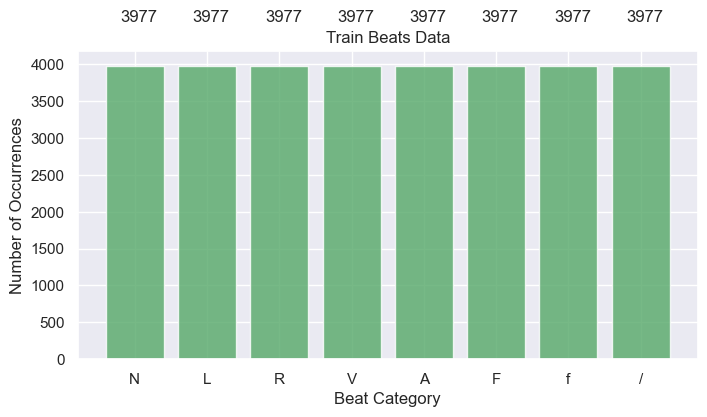

In [6]:
plot_counts(pd.DataFrame(train_beats),'Train Beats Data','g')

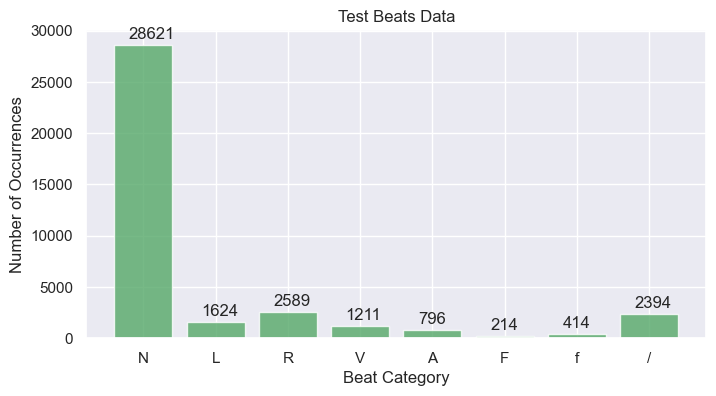

In [7]:
plot_counts(pd.DataFrame(test_beats),'Test Beats Data','g')

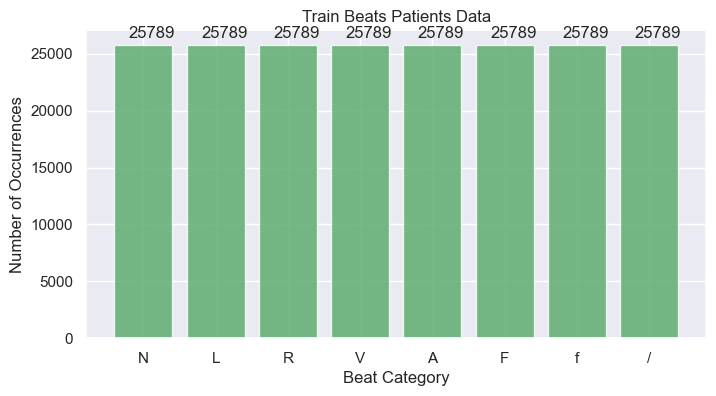

In [8]:
plot_counts(pd.DataFrame(train_beats_patients),'Train Beats Patients Data','g')

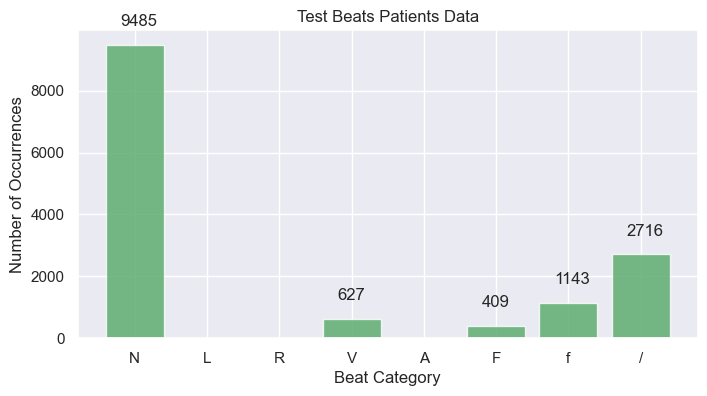

In [9]:
plot_counts(pd.DataFrame(test_beats_patients),'Test Beats Patients Data','g')

### Given Data to DataFrames

In [10]:
df = pd.DataFrame(train_beats)
df_test = pd.DataFrame(test_beats)
df_patients = pd.DataFrame(train_beats_patients)
df_test_patients = pd.DataFrame(test_beats_patients)

In [11]:
df

,0,1,2,3,4,5,6,7,8,9,...,267,268,269,270,271,272,273,274,275,276
0,0.865485,-0.165040,-0.143571,-0.154305,-0.154305,-0.197244,-0.250917,-0.293856,-0.304590,-0.304590,...,0.071122,0.049653,0.092591,0.081856,0.103326,0.092591,0.081856,0.071122,4.0,233.0
1,1.001576,0.325618,0.332117,0.338617,0.319118,0.293120,0.280121,0.286620,0.273621,0.293120,...,0.150129,0.156628,0.169628,0.169628,0.182627,0.221624,0.247623,0.260622,4.0,217.0
2,0.547689,-0.371512,-0.393932,-0.393932,-0.416351,-0.371512,-0.349093,-0.349093,-0.393932,-0.416351,...,0.009620,0.009620,0.032040,0.076879,0.009620,-0.057639,-0.080058,-0.057639,4.0,200.0
3,-0.122889,0.688807,0.741174,0.776086,0.741174,0.671351,0.584072,0.557888,0.610256,0.662623,...,-0.803666,-0.751299,-0.672747,-0.707659,-0.751299,-0.760027,-0.742571,-0.690203,6.0,208.0
4,1.374999,-0.753326,-0.730192,-0.799594,-0.799594,-0.868996,-0.776460,-0.730192,-0.730192,-0.753326,...,0.403372,0.310836,0.287702,0.287702,0.287702,0.380238,0.403372,0.310836,2.0,111.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31811,0.315186,-0.376700,-0.356645,-0.326563,-0.326563,-0.336590,-0.366672,-0.366672,-0.346618,-0.316536,...,1.739068,1.698959,1.668877,1.608713,1.578631,1.558576,1.558576,1.488385,8.0,217.0
31812,0.483996,0.271358,0.296374,0.321391,0.283866,0.283866,0.246342,0.246342,0.233834,0.258850,...,0.483996,0.471488,0.458980,0.433964,0.483996,0.458980,0.458980,0.446472,2.0,109.0
31813,0.316990,-0.340815,-0.393439,-0.419751,-0.446064,-0.446064,-0.393439,-0.525000,-0.577625,-0.603937,...,-0.288190,-0.261878,-0.130317,-0.182942,-0.182942,-0.182942,-0.077693,0.027556,1.0,201.0
31814,0.447568,-0.045107,-0.056056,-0.077952,-0.034159,0.020583,0.097221,0.097221,0.151963,0.151963,...,-0.154591,-0.110797,-0.077952,-0.056056,-0.099849,-0.099849,-0.110797,-0.067004,4.0,215.0


In [12]:
df_test

,0,1,2,3,4,5,6,7,8,9,...,267,268,269,270,271,272,273,274,275,276
0,0.237918,0.161789,0.096536,0.140038,0.205292,0.205292,0.150914,0.107411,0.096536,0.129163,...,0.324923,0.335799,0.346674,0.324923,0.303172,0.292296,0.357550,0.390177,1.0,228.0
1,0.847829,0.847829,0.815520,0.799366,0.799366,0.831675,0.799366,0.799366,0.734750,0.718596,...,-0.072958,-0.024496,0.007813,-0.040650,-0.072958,-0.089112,-0.089112,-0.024496,1.0,104.0
2,1.078731,-0.263065,-0.348711,-0.434358,-0.462906,-0.462906,-0.434358,-0.405809,-0.434358,-0.548553,...,-0.091772,-0.034674,-0.063223,0.022424,-0.034674,-0.063223,-0.120320,-0.120320,1.0,201.0
3,0.053720,0.265629,0.250492,0.182379,0.167243,0.099129,0.083993,0.053720,0.031016,0.008311,...,1.120831,1.037581,0.939195,0.863514,0.765127,0.734855,0.659173,0.575923,8.0,217.0
4,2.016727,1.300436,1.300436,1.300436,1.109425,0.966167,1.013920,1.013920,1.061673,1.061673,...,-0.657424,-0.848435,-1.087199,-1.134951,-1.039446,-0.848435,-0.991693,-1.039446,1.0,114.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37858,1.975240,-0.568570,-0.528192,-0.528192,-0.541652,-0.555111,-0.595489,-0.582030,-0.635867,-0.608948,...,0.615849,0.575471,0.521634,0.400500,0.346663,0.238988,0.198611,0.117855,1.0,119.0
37859,2.156441,-0.207554,-0.102488,0.002579,0.081379,0.133912,0.186445,0.238978,0.212712,0.107645,...,0.028846,0.133912,0.160179,0.212712,0.186445,0.186445,0.081379,0.133912,4.0,205.0
37860,3.944573,-0.605275,-0.580681,-0.629869,-0.629869,-0.703650,-0.654463,-0.679056,-0.654463,-0.629869,...,-0.605275,-0.629869,-0.679056,-0.654463,-0.728244,-0.703650,-0.703650,-0.654463,1.0,121.0
37861,1.586023,-0.611111,-0.627883,-0.644655,-0.678200,-0.678200,-0.627883,-0.644655,-0.594339,-0.560795,...,0.227490,0.143629,0.076541,-0.007319,-0.107951,-0.141495,-0.175039,-0.242127,1.0,117.0


In [13]:
df_patients

,0,1,2,3,4,5,6,7,8,9,...,267,268,269,270,271,272,273,274,275,276
0,-0.406299,-0.098454,-0.067670,-0.021493,0.024684,0.117037,0.209390,0.394097,0.409489,0.347920,...,-0.067670,0.055468,0.132429,0.209390,0.317136,0.347920,0.240175,0.101645,6.0,208.0
1,0.605524,0.406723,0.444590,0.454057,0.491923,0.529790,0.577124,0.633924,0.652857,0.681257,...,-0.360078,-0.379012,-0.397945,-0.369545,-0.369545,-0.407412,-0.416878,-0.454745,4.0,223.0
2,1.039539,0.141544,0.037929,0.072468,0.141544,0.279697,0.210621,0.107006,0.037929,0.003391,...,-1.274524,-1.136371,-1.032757,-1.032757,-1.032757,-1.101833,-1.101833,-1.101833,2.0,111.0
3,0.254837,-0.259350,-0.259350,-0.250485,-0.250485,-0.277080,-0.268215,-0.303676,-0.250485,-0.259350,...,0.396681,0.334624,0.281433,0.272567,0.228241,0.210510,0.175049,0.121857,8.0,217.0
4,0.645459,0.762654,0.729170,0.729170,0.695685,0.662201,0.628716,0.545005,0.578490,0.561747,...,-0.124684,-0.124684,-0.141426,-0.158168,-0.158168,-0.091199,-0.107942,-0.074457,7.0,104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206307,0.568766,-0.593125,-1.755017,-1.984526,-1.539852,-1.009111,-0.607470,-0.435338,-0.363616,-0.320583,...,1.888445,2.591318,3.337223,4.111817,4.671246,4.929445,4.556492,3.523699,5.0,209.0
206308,1.554196,-0.053106,0.085454,0.140878,0.085454,0.057742,0.030030,-0.053106,-0.080819,-0.025394,...,0.611984,0.611984,0.584272,0.556560,0.501136,0.556560,0.639696,0.695120,5.0,222.0
206309,0.414616,0.263250,0.318292,0.373334,0.442137,0.428376,0.414616,0.428376,0.497179,0.524700,...,-0.328450,-0.287169,-0.287169,-0.273408,-0.314690,-0.314690,-0.287169,-0.204606,6.0,208.0
206310,0.177070,0.637800,0.717236,0.796673,0.796673,0.780785,0.764898,0.812560,0.876109,0.939658,...,-0.315434,-0.283659,-0.283659,-0.235998,-0.188336,-0.061238,0.034085,0.113522,6.0,208.0


In [14]:
df_test_patients

,0,1,2,3,4,5,6,7,8,9,...,267,268,269,270,271,272,273,274,275,276
0,-0.794522,1.093482,1.055340,0.979057,0.940916,0.979057,0.979057,0.998128,0.921845,0.883704,...,0.979057,1.017199,1.055340,1.112553,1.131623,1.131623,1.112553,1.112553,8.0,104.0
1,-0.745154,1.024784,0.987126,0.968297,0.892980,0.855322,0.817664,0.817664,0.798834,0.723518,...,1.269563,1.250734,1.250734,1.307221,1.326050,1.344879,1.326050,1.250734,8.0,104.0
2,-0.602342,1.209914,1.209914,1.209914,1.111422,1.131120,1.012929,0.973533,0.953834,0.973533,...,1.269009,1.308406,1.249311,1.249311,1.288707,1.308406,1.308406,1.308406,8.0,104.0
3,-0.474419,1.197464,1.178024,1.139143,1.178024,1.119702,1.061381,0.983619,0.964178,0.905857,...,1.275226,1.333548,1.294667,1.294667,1.275226,1.255786,1.314107,1.352988,8.0,104.0
4,-0.429334,0.233549,0.196722,0.196722,0.233549,0.307203,0.344030,0.233549,0.196722,0.159896,...,0.822779,0.859606,1.006913,1.006913,0.896433,0.859606,0.896433,1.043740,7.0,104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14375,1.151898,0.592183,0.432265,0.458918,0.432265,0.378958,0.378958,0.325652,0.352305,0.405612,...,0.298999,0.245693,0.219040,0.192387,0.139081,0.085774,0.219040,0.272346,1.0,119.0
14376,1.517943,0.405797,0.378672,0.270170,0.215919,0.215919,0.215919,0.324421,0.243044,0.405797,...,0.460048,0.460048,0.297295,0.297295,0.297295,0.188793,0.134542,0.188793,1.0,119.0
14377,1.373321,0.199526,0.114159,0.028792,0.007450,0.028792,-0.056575,-0.013892,0.028792,0.114159,...,0.605019,0.540994,0.476968,0.498310,0.455627,0.476968,0.370260,0.412943,1.0,119.0
14378,1.777072,0.235666,0.212660,0.281678,0.304684,0.327690,0.419714,0.373702,0.396708,0.442720,...,0.258672,0.258672,0.235666,0.258672,0.327690,0.258672,0.166648,0.166648,1.0,119.0


### Visualising all Types of Heartbeat Classes

Text(0.5, 1.0, 'Train Beats')

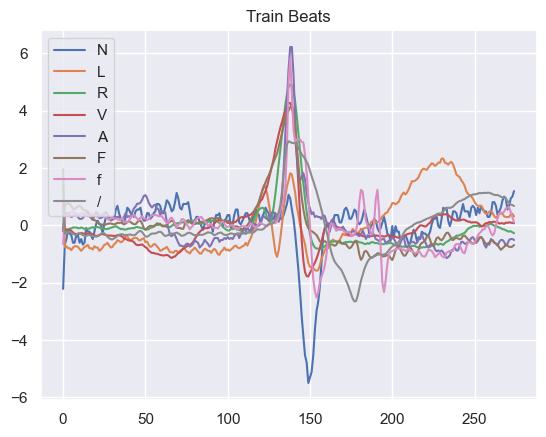

In [15]:
plt.plot(train_beats[14, 0:275], label='N')
plt.plot(train_beats[4, 0:275], label='L')
plt.plot(train_beats[5, 0:275], label='R')
plt.plot(train_beats[0, 0:275], label='V')
plt.plot(train_beats[11, 0:275], label='A')
plt.plot(train_beats[3, 0:275], label='F')
plt.plot(train_beats[10, 0:275], label='f')
plt.plot(train_beats[7, 0:275], label='/')
plt.legend()
plt.title('Train Beats')

Text(0.5, 1.0, 'Train Beats Leave-out Patients')

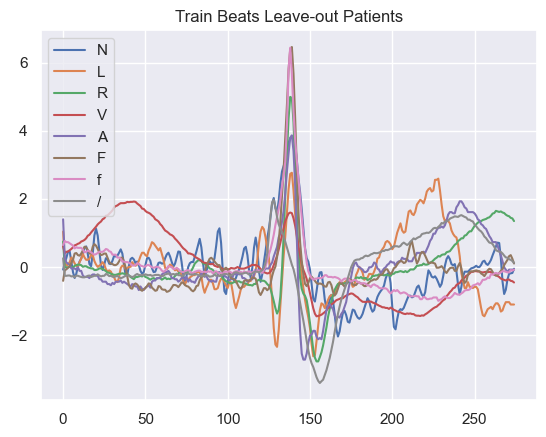

In [16]:
plt.plot(train_beats_patients[8, 0:275], label='N')
plt.plot(train_beats_patients[2, 0:275], label='L')
plt.plot(train_beats_patients[6, 0:275], label='R')
plt.plot(train_beats_patients[1, 0:275], label='V')
plt.plot(train_beats_patients[5, 0:275], label='A')
plt.plot(train_beats_patients[0, 0:275], label='F')
plt.plot(train_beats_patients[4, 0:275], label='f')
plt.plot(train_beats_patients[3, 0:275], label='/')
plt.legend()
plt.title('Train Beats Leave-out Patients')

### Splitting the Data

In [17]:
X_train = train_beats[:,:275]
t_train = train_beats[:,275]
X_train_test = test_beats[:,:275]
t_train_test = test_beats[:,275]

X_train_patients = train_beats_patients[:,:275]
t_train_patients = train_beats_patients[:,275]
X_train_patients_test = test_beats_patients[:,:275]
t_train_patients_test = test_beats_patients[:,275]

## Classification of Beat Holdout Data with Support Vector Machines

In [18]:
def train_SVM(X, t, X_test, t_test):
#     print("Training Data with RBF...")
#     rbf = SVC(kernel='rbf', gamma=0.5, C=0.1).fit(X, t)
#     print("Predicting Data with RBF...")
#     rbf_pred = rbf.predict(X_test)
#     rbf_accuracy = accuracy_score(t_test, rbf_pred)
#     rbf_precision = precision_score(t_test, rbf_pred, average='weighted')
#     rbf_recall = recall_score(t_test, rbf_pred, average='weighted')
#     rbf_f1 = f1_score(t_test, rbf_pred, average='weighted')
#     rbf_confusion = confusion_matrix(t_test, rbf_pred)
#     print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
#     print('Precision (RBF Kernel): ', "%.2f" % (rbf_precision*100))
#     print('Recall (RBF Kernel): ', "%.2f" % (rbf_recall*100))
#     print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))
#     print('Confusion Matrix (RBF Kernel)')
#     print(rbf_confusion)
    
#     return rbf

    print("Training Data with Poly...")
    poly = SVC(kernel='poly', degree=8, C=1).fit(X, t)

    print("Predicting Data with Poly...")
    poly_pred = poly.predict(X_test)

    # accuracy, precision, recall, f1score and a confusion matrix
    poly_accuracy = accuracy_score(t_test, poly_pred)
    poly_precision = precision_score(t_test, poly_pred, average='weighted')
    poly_recall = recall_score(t_test, poly_pred, average='weighted')
    poly_f1 = f1_score(t_test, poly_pred, average='weighted')
    poly_confusion = confusion_matrix(t_test, poly_pred)
    print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
    print('Precision (Polynomial Kernel): ', "%.2f" % (poly_precision*100))
    print('Recall (Polynomial Kernel): ', "%.2f" % (poly_recall*100))
    print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))
    print('Confusion Matrix (Polynomial Kernel)')
    print(poly_confusion)

    return poly

### Beat Holdout Data
#### For Training the Data

In [19]:
# print("Classifying Train Beats Data")
# train_beats_SVM_rbf = train_SVM(X_train, t_train, X_train_test, t_train_test)

# print("Classifying Train Beats Data")
# train_beats_SVM = train_SVM(X_train, t_train, X_train_test, t_train_test)

#### To Save the Trained Model

In [20]:
# joblib.dump(train_beats_SVM_rbf, './models/train_beats_SVM_rbf.joblib')

# joblib.dump(train_beats_SVM, './models/train_beats_SVM.joblib')

In [21]:
def loadFromModel(model, X_test, t_test):
    print("Predicting Data...")
    poly_pred = model.predict(X_test)

    # accuracy, precision, recall, f1score and a confusion matrix
    poly_accuracy = accuracy_score(t_test, poly_pred)
    poly_precision = precision_score(t_test, poly_pred, average='weighted')
    poly_recall = recall_score(t_test, poly_pred, average='weighted')
    poly_f1 = f1_score(t_test, poly_pred, average='weighted')
    poly_confusion = confusion_matrix(t_test, poly_pred)
    print('Accuracy : ', "%.2f" % (poly_accuracy*100))
    print('Precision : ', "%.2f" % (poly_precision*100))
    print('Recall : ', "%.2f" % (poly_recall*100))
    print('F1 : ', "%.2f" % (poly_f1*100))
    print('Confusion Matrix ')
    print(poly_confusion)
    return poly_pred

#### To load the Saved Model

In [22]:
train_beats_SVM_rbf = joblib.load('./models/train_beats_SVM_rbf.joblib')
print('BEAT HOLDOUT DATA SVM RBF KERNEL METRICS')
train_beats_SVM_rbf_pred = loadFromModel(train_beats_SVM_rbf, X_train_test, t_train_test)

BEAT HOLDOUT DATA SVM RBF KERNEL METRICS
Predicting Data...
Accuracy :  82.72
Precision :  85.84
Recall :  82.72
F1 :  78.39
Confusion Matrix 
[[28621     0     0     0     0     0     0     0]
 [  655   969     0     0     0     0     0     0]
 [ 1851     0   738     0     0     0     0     0]
 [ 1052     0     0   153     0     6     0     0]
 [  689     0     0     0   107     0     0     0]
 [  166     0     0     0     0    48     0     0]
 [  346     0     0     0     0     0    68     0]
 [ 1776     0     0     0     0     0     3   615]]


In [23]:
train_beats_SVM = joblib.load('./models/train_beats_SVM.joblib')
print('BEAT HOLDOUT DATA SVM POLYNOMIAL KERNEL METRICS')
train_beats_SVM_pred = loadFromModel(train_beats_SVM, X_train_test, t_train_test)

BEAT HOLDOUT DATA SVM POLYNOMIAL KERNEL METRICS
Predicting Data...
Accuracy :  96.58
Precision :  97.74
Recall :  96.58
F1 :  96.99
Confusion Matrix 
[[27555     4     1   226   369   408    57     1]
 [    2  1619     0     1     0     1     1     0]
 [   10     0  2562    10     6     0     1     0]
 [   36     0     1  1134     7    30     3     0]
 [   58     0     5     6   727     0     0     0]
 [    6     0     0     8     2   198     0     0]
 [    5     0     0     1     0     0   401     7]
 [    2     0     0     1     0     0    19  2372]]


#### Permutaion Feature Importance on Beat Holdout Data
#### To Train Model with PFI

In [24]:
# perm = PermutationImportance(SVC(kernel='poly', degree=8, C=1), cv=5)
# perm.fit(X_train, t_train)

# joblib.dump(perm, './models/train_beats_SVM_PFI.joblib')

#### To Load PFI Model

In [25]:
perm = joblib.load('./models/train_beats_SVM_PFI.joblib')
perm

PermutationImportance(cv=5, estimator=SVC(C=1, degree=8, kernel='poly'))

In [26]:
# Save Data to CSV
data_perm = pd.DataFrame({'features': [i for i in range(perm.feature_importances_.shape[0])],'importance':perm.feature_importances_})

data_perm = data_perm.sort_values(by=['importance'],ascending=False)
# data_perm.to_csv('train_data_perm.csv')

#### Feature Extraction and Re-training with New Data

In [27]:
#Making list of positive weights
arrr = [i for i in np.array(data_perm['importance']) if i >= 0]
print(len(arrr))

#Extracting columns index based on weights
train_beats_feat = np.sort(np.array(data_perm['features'][0:len(arrr)+1]))

# New Data
train_beats_new_data = df.loc[:,train_beats_feat]
test_beats_new_data = df_test.loc[:,train_beats_feat]

268


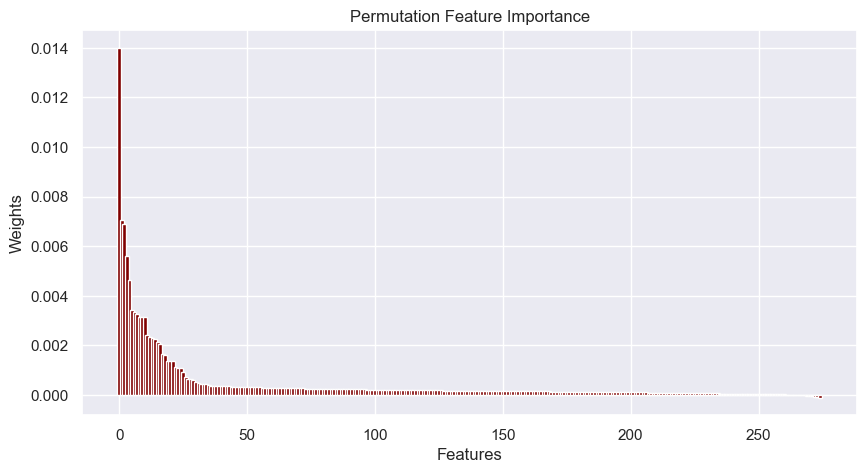

In [28]:
fig = plt.figure(figsize = (10, 5))
plt.bar(data_perm['features'],data_perm['importance'],color='maroon', width=1.5)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Permutation Feature Importance")
plt.show()

In [29]:
eli5.show_weights(perm, top=None)

Weight,Feature
0.0140 ± 0.0025,x0
0.0070 ± 0.0008,x1
0.0069 ± 0.0007,x2
0.0056 ± 0.0008,x3
0.0047 ± 0.0006,x4
0.0035 ± 0.0005,x5
0.0034 ± 0.0007,x6
0.0033 ± 0.0006,x7
0.0032 ± 0.0006,x8
0.0032 ± 0.0004,x9


#### Training with New Data

In [30]:
# print("Classifying Train Beats Data")
# train_beats_SVM_new = train_SVM(train_beats_new_data, t_train, test_beats_new_data, t_train_test)
# joblib.dump(train_beats_SVM_new, './models/train_beats_SVM_new.joblib')

#### Loading Saved Model

In [31]:
train_beats_SVM_new = joblib.load('./models/train_beats_SVM_new.joblib')
print('BEAT HOLDOUT DATA SVM POLYNOMIAL KERNEL METRICS AFTER PFI')
train_beats_SVM_pred_new = loadFromModel(train_beats_SVM_new, test_beats_new_data, t_train_test)

BEAT HOLDOUT DATA SVM POLYNOMIAL KERNEL METRICS AFTER PFI
Predicting Data...
Accuracy :  96.46
Precision :  97.66
Recall :  96.46
F1 :  96.88
Confusion Matrix 
[[27526     8     1   242   360   418    65     1]
 [    3  1617     0     1     0     1     2     0]
 [   10     0  2560    10     8     0     1     0]
 [   30     0     3  1133     7    32     6     0]
 [   65     0     6     5   720     0     0     0]
 [    5     0     0     8     2   199     0     0]
 [    6     0     0     1     0     0   400     7]
 [    4     0     0     1     0     0    22  2367]]


### Leave Out Patient Data
#### For Training the Data

In [32]:
# print("Classifying Train Beats Hold Out Data")
# train_patients_SVM = train_SVM(X_train_patients, t_train_patients, X_train_patients_test, t_train_patients_test)

#### To Save the Trained Model


In [33]:
# joblib.dump(train_patients_SVM, './models/patients/train_patients_SVM.joblib')

#### To load the Saved Model

In [34]:
train_patients_SVM = joblib.load('./models/patients/train_patients_SVM.joblib')
print('LEAVE OUT PATIENT DATA SVM POLYNOMIAL KERNEL METRICS')
train_patients_SVM_pred = loadFromModel(train_patients_SVM, X_train_patients_test, t_train_patients_test)

LEAVE OUT PATIENT DATA SVM POLYNOMIAL KERNEL METRICS
Predicting Data...
Accuracy :  98.84
Precision :  99.05
Recall :  98.84
F1 :  98.92
Confusion Matrix 
[[9357    1   11   18   52   46    0]
 [   0    0    0    0    0    0    0]
 [   1    0  619    0    7    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0  409    0    0]
 [   0    0    0    0    0 1140    3]
 [   0    0    0    0    0   28 2688]]


/Users/savan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Permutaion Feature Importance on Beat Holdout Data
#### To Train Model with PFI

In [35]:
# perm_patients = PermutationImportance(SVC(kernel='poly', degree=8, C=1), cv=5)
# perm_patients.fit(X_train_patients, t_train_patients)

# joblib.dump(perm_patients, './models/patients/train_patients_SVM_PFI.joblib')

#### To Load PFI Model

In [36]:
perm_patients = joblib.load('./models/patients/train_patients_SVM_PFI.joblib')
perm_patients

PermutationImportance(cv=5, estimator=SVC(C=1, degree=8, kernel='poly'))

In [37]:
# Save Data to CSV
data_perm_patients = pd.DataFrame({'features': [i for i in range(perm_patients.feature_importances_.shape[0])],'importance':perm_patients.feature_importances_})

data_perm_patients = data_perm_patients.sort_values(by=['importance'],ascending=False)
# data_perm_patients.to_csv('train_patients_perm.csv')

#### Feature Extraction and Re-training with New Data

In [38]:
#Making list of positive weights
arrr_p = [i for i in np.array(data_perm_patients['importance']) if i >= 0]
print(len(arrr_p))

#Extracting columns index based on weights
train_p_feat = np.sort(np.array(data_perm_patients['features'][0:len(arrr)+1]))

# New Data
train_patients_new_data = df_patients.loc[:,train_p_feat]
test_patients_new_data = df_test_patients.loc[:,train_p_feat]

266


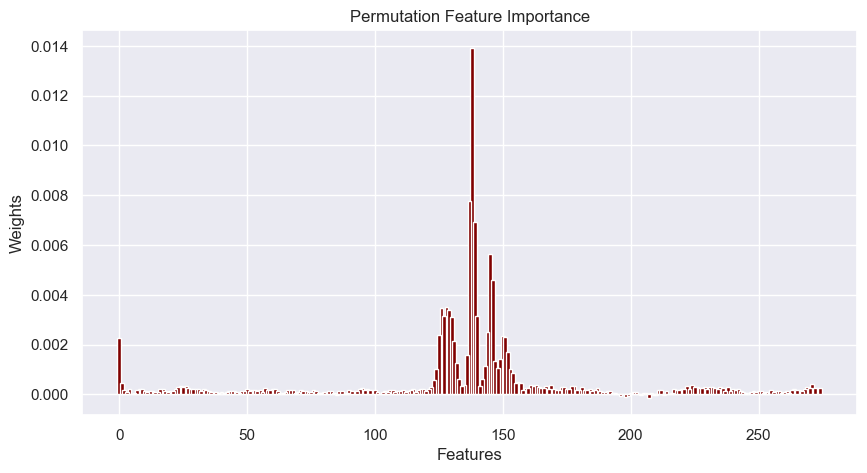

In [39]:
fig = plt.figure(figsize = (10, 5))
plt.bar(data_perm_patients['features'],data_perm_patients['importance'],color='maroon', width=1.5)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Permutation Feature Importance")
plt.show()

In [40]:
eli5.show_weights(perm_patients, top=None)

Weight,Feature
0.0139 ± 0.0041,x138
0.0078 ± 0.0029,x137
0.0069 ± 0.0029,x139
0.0057 ± 0.0026,x145
0.0046 ± 0.0028,x146
0.0035 ± 0.0028,x128
0.0035 ± 0.0023,x126
0.0034 ± 0.0023,x129
0.0032 ± 0.0025,x127
0.0032 ± 0.0029,x140


#### Training with New Data

In [41]:
# print("Classifying Train Beats Hold Out Data")
# train_patients_SVM_new = train_SVM(train_patients_new_data, t_train_patients, test_patients_new_data, t_train_patients_test)
# joblib.dump(train_patients_SVM_new, 'models/patients/train_patients_SVM_new.joblib')

#### Loading Saved Model

In [42]:
train_patients_SVM_new1 = joblib.load('models/patients/train_patients_SVM_new.joblib')
print('LEAVE OUT PATIENT DATA SVM POLYNOMIAL KERNEL METRICS AFTER PFI')
train_patients_SVM_new_pred = loadFromModel(train_patients_SVM_new1, test_patients_new_data, t_train_patients_test)

LEAVE OUT PATIENT DATA SVM POLYNOMIAL KERNEL METRICS AFTER PFI
Predicting Data...
Accuracy :  98.83
Precision :  99.04
Recall :  98.83
F1 :  98.92
Confusion Matrix 
[[9354    1   11   18   49   52    0]
 [   0    0    0    0    0    0    0]
 [   1    0  619    0    7    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0  409    0    0]
 [   0    0    0    0    0 1140    3]
 [   0    0    0    0    0   26 2690]]


/Users/savan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Classification of Beat Holdout Data with Random Forest Classifier


In [43]:
def train_RFC(X, t, X_test, t_test):
    
    print("Training Data with RFC...")
    forest = RandomForestClassifier(n_estimators=275,
                                random_state=0)
    forest.fit(X, t)
    print('Training accuracy: ',"%.2f" % (np.mean(forest.predict(X) == t)*100))
    
    print("Predicting Data with RFC...")
    rfc_predict = forest.predict(X_test)
    
    # accuracy, precision, recall, f1score and a confusion matrix
#     rfc_accuracy = accuracy_score(t_test, rfc_predict)
    rfc_accuracy = np.mean(rfc_predict == t_test)*100
    print('Test accuracy:', "%.2f"% (rfc_accuracy))
    rfc_precision = precision_score(t_test, rfc_predict, average='weighted')
    rfc_recall = recall_score(t_test, rfc_predict, average='weighted')
    rfc_f1 = f1_score(t_test, rfc_predict, average='weighted')
    rfc_confusion = confusion_matrix(t_test, rfc_predict)
#     print('Accuracy: ', "%.2f" % (rfc_accuracy*100))
    print('Precision: ', "%.2f" % (rfc_precision*100))
    print('Recall: ', "%.2f" % (rfc_recall*100))
    print('F1: ', "%.2f" % (rfc_f1*100))
    print('Confusion Matrix')
    print(rfc_confusion)
    
    return forest

### Beat Holdout Data
#### For Training the Data

In [44]:
# print("RFC Train Beats Data")
# forest = train_RFC(X_train, t_train, X_train_test, t_train_test)

#### To Save the Trained Model

In [45]:
# joblib.dump(forest, './models/train_beats_RFC.joblib')

In [46]:
def loadFromRFCModel(model, X_test, t_test):
    
    print("Predicting Data with RFC...")
    rfc_predict = model.predict(X_test)
    
    # accuracy, precision, recall, f1score and a confusion matrix
#     rfc_accuracy = accuracy_score(t_test, rfc_predict)
    rfc_accuracy = np.mean(rfc_predict == t_test)*100
    print('Test accuracy:', "%.2f"% (rfc_accuracy))
    rfc_precision = precision_score(t_test, rfc_predict, average='weighted')
    rfc_recall = recall_score(t_test, rfc_predict, average='weighted')
    rfc_f1 = f1_score(t_test, rfc_predict, average='weighted')
    rfc_confusion = confusion_matrix(t_test, rfc_predict)
#     print('Accuracy: ', "%.2f" % (rfc_accuracy*100))
    print('Precision: ', "%.2f" % (rfc_precision*100))
    print('Recall: ', "%.2f" % (rfc_recall*100))
    print('F1: ', "%.2f" % (rfc_f1*100))
    print('Confusion Matrix')
    print(rfc_confusion)
    
    return forest

#### To load the Saved Model

In [47]:
forest = joblib.load('./models/train_beats_RFC.joblib')
print('TRAIN BEATS DATA RFC METRICS')
forest_pred = loadFromModel(forest, X_train_test, t_train_test)

TRAIN BEATS DATA RFC METRICS
Predicting Data...
Accuracy :  97.03
Precision :  97.58
Recall :  97.03
F1 :  97.21
Confusion Matrix 
[[27741    34    12   293   400    74    55    12]
 [    5  1615     0     2     0     0     2     0]
 [    9     0  2565     7     8     0     0     0]
 [   28     3     7  1145    13    13     2     0]
 [   63     0    12     5   715     0     1     0]
 [   11     0     1    16     3   181     2     0]
 [    3     0     1     2     0     0   395    13]
 [    0     0     0     2     0     0    10  2382]]


In [48]:
importance_vals = forest.feature_importances_
print(importance_vals)

[0.00437665 0.00257313 0.00222197 0.00205188 0.0022593  0.00190149
 0.00164016 0.00164824 0.00169725 0.00173931 0.00150491 0.00205334
 0.00150913 0.00147534 0.00143481 0.00139214 0.00157181 0.00161604
 0.00184489 0.00178122 0.00161147 0.00144085 0.00118838 0.00123489
 0.00128357 0.0010013  0.00114149 0.00083308 0.00102314 0.00141428
 0.00092129 0.0012108  0.00101247 0.00105888 0.00109337 0.00142438
 0.00125342 0.0010548  0.00131559 0.00158717 0.00135655 0.00127814
 0.00122643 0.00152    0.00167357 0.00165822 0.00129917 0.00132799
 0.00131563 0.00138269 0.00135166 0.00134188 0.00149653 0.00142085
 0.00135797 0.00144705 0.00134421 0.00139576 0.00138206 0.00132268
 0.00148547 0.00126975 0.00153099 0.00160315 0.00175673 0.00173989
 0.00177209 0.00256348 0.00258521 0.00233727 0.0030337  0.00294509
 0.00273907 0.00268955 0.00214488 0.00337754 0.00316344 0.00256604
 0.00207679 0.00199356 0.00176561 0.00208559 0.00208927 0.0024106
 0.00256409 0.00249576 0.00409316 0.0049082  0.00622866 0.00807

#### Permutaion Feature Importance on Beat Holdout Data
#### To Train Model with PFI

In [49]:
# perm_RFC = PermutationImportance(forest, cv=5)
# perm_RFC.fit(X_train, t_train)

# joblib.dump(perm_RFC, './models/train_beats_RFC_PFI.joblib')

#### To Load PFI Model

In [50]:
perm_RFC = joblib.load('./models/train_beats_RFC_PFI.joblib')
perm_RFC

PermutationImportance(cv=5,
                      estimator=RandomForestClassifier(n_estimators=250,
                                                       random_state=0))

In [51]:
# Save Data to CSV
data_perm_RFC = pd.DataFrame({'features': [i for i in range(perm_RFC.feature_importances_.shape[0])],'importance':perm_RFC.feature_importances_})
data_perm_RFC = data_perm_RFC.sort_values(by=['importance'],ascending=False)
# data_perm_RFC.to_csv('train_data_perm_RFC.csv')

#### Feature Extraction and Re-training with New Data


In [52]:
#Making list of positive weights
arrr_RFC = [i for i in np.array(data_perm_RFC['importance']) if i >= 0]
print(len(arrr_RFC))

#Extracting columns index based on weights
train_beats_feat_RFC = np.sort(np.array(data_perm['features'][0:len(arrr)+1]))

# New Data
train_beats_new_data_RFC = df.loc[:,train_beats_feat_RFC]
test_beats_new_data_RFC = df_test.loc[:,train_beats_feat_RFC]

107


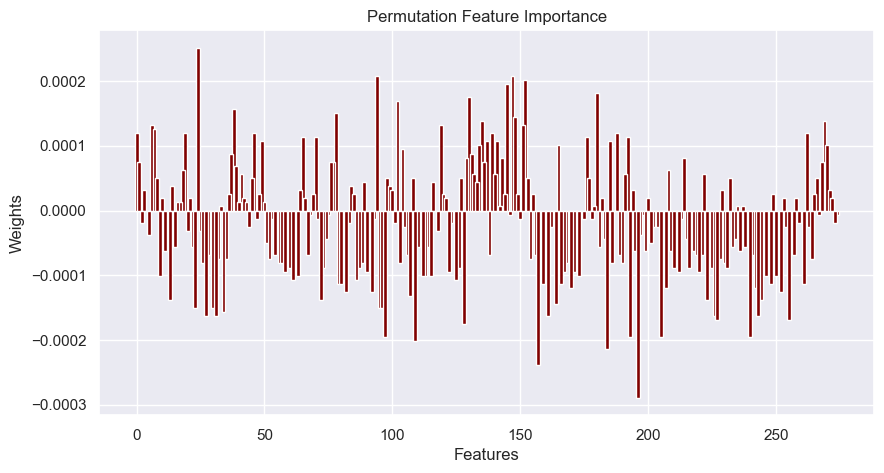

In [53]:
fig = plt.figure(figsize = (10, 5))
plt.bar(data_perm_RFC['features'],data_perm_RFC['importance'],color='maroon', width=1.5)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Permutation Feature Importance")
plt.show()

In [54]:
eli5.show_weights(perm_RFC, top=None)

Weight,Feature
0.0003 ± 0.0005,x24
0.0002 ± 0.0008,x94
0.0002 ± 0.0012,x147
0.0002 ± 0.0008,x152
0.0002 ± 0.0010,x145
0.0002 ± 0.0007,x180
0.0002 ± 0.0005,x130
0.0002 ± 0.0004,x102
0.0002 ± 0.0003,x38
0.0002 ± 0.0003,x78


#### Training with New Data

In [55]:
# print("RFC Train Beats Data")
# forest_new = train_RFC(train_beats_new_data_RFC, t_train, test_beats_new_data_RFC, t_train_test)

# joblib.dump(forest_new, './models/train_beats_RFC_new.joblib')

#### Loading Saved Model

In [56]:
forest_new = joblib.load('./models/train_beats_RFC_new.joblib')
print('TRAIN BEATS DATA RFC METRICS AFTER PFI')
forest_new_pred = loadFromModel(forest_new, test_beats_new_data_RFC, t_train_test)

TRAIN BEATS DATA RFC METRICS AFTER PFI
Predicting Data...
Accuracy :  97.01
Precision :  97.58
Recall :  97.01
F1 :  97.19
Confusion Matrix 
[[27728    32    14   298   404    78    55    12]
 [    4  1617     0     1     0     0     2     0]
 [   10     0  2565     8     6     0     0     0]
 [   26     2     7  1146    13    14     3     0]
 [   62     0    11     5   717     0     1     0]
 [   14     0     0    16     3   180     1     0]
 [    3     0     1     3     0     0   395    12]
 [    0     0     0     2     0     0     9  2383]]


### Leave Out Patient Data
#### For Training the Data

In [57]:
# print("RFC Train Beats Data")
# forest1 = train_RFC(X_train_patients, t_train_patients, X_train_patients_test, t_train_patients_test)

#### To Save the Trained Model


In [58]:
# joblib.dump(forest1, './models/patients/train_patients_RFC.joblib')

#### To load the Saved Model

In [59]:
forest1 = joblib.load('./models/patients/train_patients_RFC.joblib')
print('LEAVE OUT PATIENT DATA RFC METRICS')
forest1_pred = loadFromModel(forest1, X_train_test, t_train_test)

LEAVE OUT PATIENT DATA RFC METRICS
Predicting Data...
Accuracy :  99.70
Precision :  99.71
Recall :  99.70
F1 :  99.71
Confusion Matrix 
[[28511     3     2    56    32     8     1     8]
 [    0  1624     0     0     0     0     0     0]
 [    1     0  2588     0     0     0     0     0]
 [    1     0     0  1210     0     0     0     0]
 [    0     0     0     0   796     0     0     0]
 [    0     0     0     0     0   214     0     0]
 [    0     0     0     0     0     0   414     0]
 [    0     0     0     0     0     0     0  2394]]


In [60]:
importance_vals1 = forest1.feature_importances_
print(importance_vals1)

[0.00475691 0.00243473 0.00231402 0.00240704 0.00192813 0.00195187
 0.00207638 0.00207487 0.00187665 0.00169133 0.00197994 0.00163873
 0.00178713 0.00129934 0.00167387 0.0015796  0.0014846  0.00191371
 0.0017502  0.00182183 0.00173834 0.00150982 0.00139951 0.00101578
 0.00135425 0.00097798 0.00097165 0.00103048 0.00090719 0.00099251
 0.00105199 0.00106028 0.0009832  0.0010667  0.00099498 0.00088144
 0.00100195 0.00133151 0.00135883 0.00126325 0.00113522 0.00136521
 0.00117576 0.00115778 0.00127453 0.00125169 0.00141183 0.0013999
 0.00135766 0.00115646 0.00163863 0.00122957 0.00142664 0.00142414
 0.00122348 0.00114858 0.00130706 0.00128702 0.00129649 0.00115224
 0.00118988 0.00133455 0.00129882 0.00127201 0.00140001 0.00150948
 0.00180379 0.00208252 0.00174811 0.00267292 0.00245573 0.00308387
 0.00310809 0.00284171 0.0031862  0.00235702 0.00338011 0.00245787
 0.00256818 0.0022964  0.00174001 0.00171394 0.00193195 0.00260847
 0.00255197 0.00243809 0.00356646 0.00517979 0.00422992 0.00673

#### Permutaion Feature Importance on Beat Holdout Data
#### To Train Model with PFI

In [61]:
# perm_patients_RFC = PermutationImportance(forest1, cv=5)
# perm_patients_RFC.fit(X_train_patients, t_train_patients)

# joblib.dump(perm_patients_RFC, './models/patients/train_patients_RFC_PFI.joblib')

#### To Load PFI Model

In [62]:
perm_patients_RFC = joblib.load('./models/patients/train_patients_RFC_PFI.joblib')
perm_patients_RFC

PermutationImportance(cv=5,
                      estimator=RandomForestClassifier(n_estimators=250,
                                                       random_state=0))

In [63]:
# Save Data to CSV
data_perm_patients_RFC = pd.DataFrame({'features': [i for i in range(perm_patients_RFC.feature_importances_.shape[0])],'importance':perm_patients_RFC.feature_importances_})
data_perm_patients_RFC = data_perm_patients_RFC.sort_values(by=['importance'],ascending=False)
# data_perm_patients_RFC.to_csv('train_data_perm_patients_RFC.csv')

#### Feature Extraction and Re-training with New Data

In [64]:
#Making list of positive weights
arrr_patients_RFC = [i for i in np.array(data_perm_patients_RFC['importance']) if i >= 0]
print(len(arrr_patients_RFC))

#Extracting columns index based on weights
train_patients_feat_RFC = np.sort(np.array(data_perm_patients_RFC['features'][0:len(arrr_patients_RFC)+1]))

# New Data
train_patients_new_data_RFC = df_patients.loc[:,train_patients_feat_RFC]
test_patients_new_data_RFC = df_test_patients.loc[:,train_patients_feat_RFC]

169


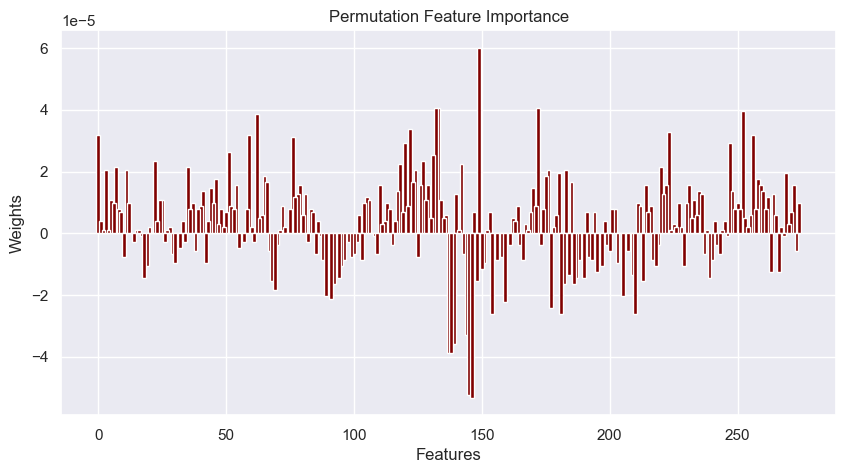

In [65]:
fig = plt.figure(figsize = (10, 5))
plt.bar(data_perm_patients_RFC['features'],data_perm_patients_RFC['importance'],color='maroon', width=1.5)
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Permutation Feature Importance")
plt.show()

In [66]:
eli5.show_weights(perm_patients_RFC, top=None)

Weight,Feature
0.0001 ± 0.0003,x149
0.0000 ± 0.0001,x133
0.0000 ± 0.0001,x132
0.0000 ± 0.0001,x172
0.0000 ± 0.0001,x252
0.0000 ± 0.0001,x62
0.0000 ± 0.0001,x122
0.0000 ± 0.0001,x223
0.0000 ± 0.0001,x0
0.0000 ± 0.0001,x256


#### Training with New Data

In [67]:
# print("RFC Train Patients Data")
# forest1_new = train_RFC(train_patients_new_data_RFC, t_train_patients, test_patients_new_data_RFC, t_train_patients_test)

# joblib.dump(forest1_new, './models/patients/train_patients_RFC_new.joblib')

#### Loading Saved Model


In [68]:
forest1_new = joblib.load('./models/patients/train_patients_RFC_new.joblib')
print('LEAVE OUT PATIENT DATA RFC METRICS AFTER PFI')
forest1_new_pred = loadFromModel(forest1_new, test_patients_new_data_RFC, t_train_patients_test)

LEAVE OUT PATIENT DATA RFC METRICS AFTER PFI
Predicting Data...
Accuracy :  99.85
Precision :  99.90
Recall :  99.85
F1 :  99.87
Confusion Matrix 
[[9464    1    8    6    5    1    0]
 [   0    0    0    0    0    0    0]
 [   1    0  626    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0  409    0    0]
 [   0    0    0    0    0 1143    0]
 [   0    0    0    0    0    0 2716]]


/Users/savan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### LIME

In [69]:
label=np.unique(t_train_patients)
explainer=LimeTabularExplainer(X_train_patients,mode='classification',training_labels=label,feature_names=[i for i in range(X_train_patients.shape[1])])

In [70]:
#explaining a single point
i = np.where(t_train_patients==1)[0][0]
exp = explainer.explain_instance(X_train_patients[i], forest1.predict_proba, num_features=20)

#change the number in num_feature and values uf x_train_paitent to pif filtered features

In [71]:
exp.show_in_notebook(show_table=True, show_predicted_value=2)

In [72]:
exp.as_list()

[('125 > 0.71', 0.008413962673972123),
 ('126 > 0.93', 0.00781625610664784),
 ('127 > 1.12', 0.006721857411547082),
 ('145 > 1.53', 0.005347064256786136),
 ('124 > 0.52', 0.004590418520697969),
 ('144 > 1.94', 0.0041552352650549955),
 ('172 <= -1.02', 0.003838894546762233),
 ('123 > 0.38', 0.003160174487923939),
 ('143 > 2.36', 0.003064674011505276),
 ('128 > 1.33', 0.002767942897851995),
 ('174 <= -0.94', 0.002567235048000464),
 ('169 <= -1.14', 0.002289129185463044),
 ('129 > 1.57', 0.0022406836549798085),
 ('-0.67 < 158 <= -0.19', -0.002198834786675515),
 ('-0.35 < 121 <= -0.12', -0.002136813236662441),
 ('92 > 0.17', -0.002039084788995149),
 ('-0.68 < 155 <= -0.10', -0.0019398326927303705),
 ('-0.68 < 156 <= -0.14', -0.001932907442502301),
 ('141 > 3.52', 0.0017307181611241208),
 ('173 <= -0.98', 0.0016885913901430367)]